In [1]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
import module.model as aux

# data
data_path = 'data/'
words = open(data_path + 'names.txt','r').read().splitlines()

print(f'Number of words in dataset: {len(words)}')

# Char to index map:
chars = list(set(''.join(words)))
chars = ['.'] + chars
char_index_map = {s:i for i, s in enumerate(chars)}


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))

block_size = 3
Xtr, Ytr = aux.get_training_data(words[:n1], char_index_map, block_size)
Xv, Yv = aux.get_training_data(words[n1:], char_index_map, block_size)

Number of words in dataset: 32033


In [2]:
model = aux.Model(char_index_map, chars, block_size=block_size, emb_dim = 10, hidden_layer_size = 200)

torch.Size([32, 30])
torch.Size([32, 30])


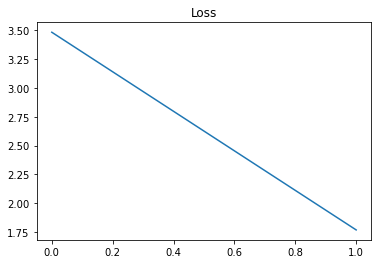

In [3]:
history = model.train(Xtr, Ytr, episodes= 2, lr=0.1)

plt.plot(history)
plt.title('Loss')
plt.show()

Layer 0: gradient mean: -9.489210697211092e-07, std: 0.0018801569240167737
Layer 2: gradient mean: 3.2254458346869797e-05, std: 0.002025082241743803
Layer 4: gradient mean: 1.0707311957958154e-05, std: 0.002030137227848172
Layer 6: gradient mean: 1.1117303074570373e-05, std: 0.001961646368727088


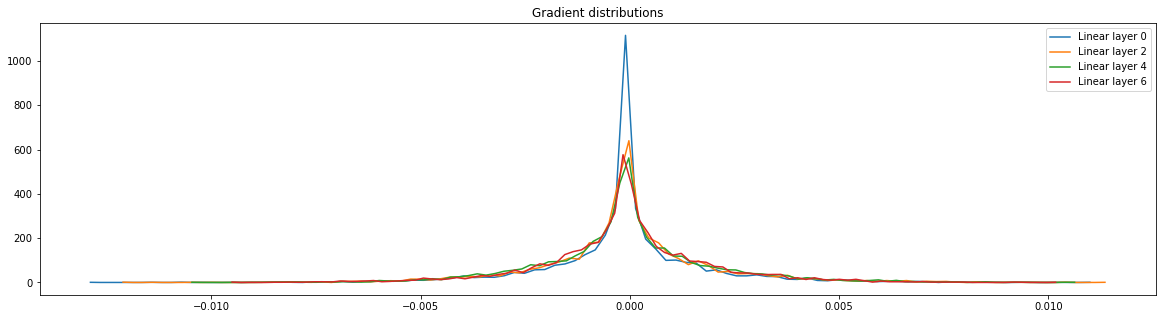

In [4]:
model.visualize_layers('linear')

Tanh Layer 1: mean -0.005143387243151665 std 0.7546819448471069 saturated 0.20906250178813934%
Tanh Layer 3: mean 0.002922528190538287 std 0.700928807258606 saturated 0.10343749821186066%
Tanh Layer 5: mean -0.001195075106807053 std 0.673427402973175 saturated 0.0768750011920929%
Tanh Layer 7: mean -0.00877892691642046 std 0.6572555303573608 saturated 0.06171875074505806%


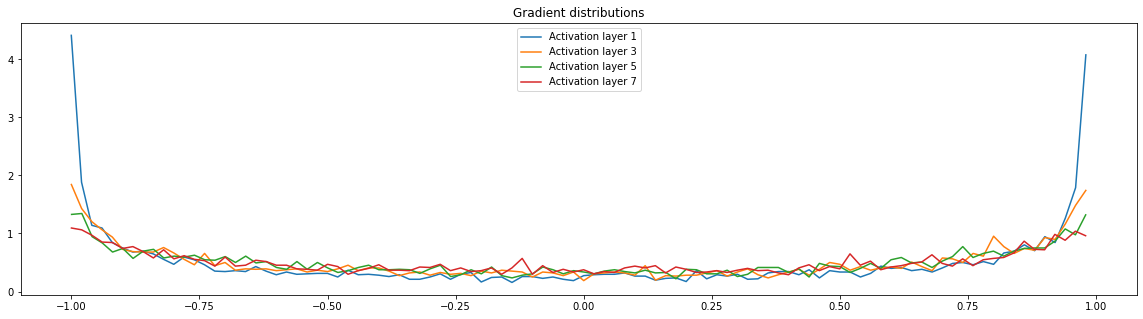

In [5]:
model.visualize_activations('tanh')

In [4]:
for c in chars[1:]:
    s = model.predict(f'..{c}')
    print(f'Name starting with {c}: {s}')

Name starting with z: ..zaeqa.
Name starting with g: ..ga.
Name starting with d: ..dena.
Name starting with n: ..na.
Name starting with w: ..wns.
Name starting with t: ..teay.
Name starting with s: ..sa.
Name starting with i: ..ionsq.
Name starting with j: ..jaezgat.
Name starting with f: ..fmn.
Name starting with c: ..cden.
Name starting with y: ..yaeiga.
Name starting with e: ..eaeiga.
Name starting with x: ..xsa.
Name starting with q: ..qeiga.
Name starting with o: ..onsqa.
Name starting with v: ..vionsqa.
Name starting with l: ..ls.
Name starting with b: ..bniqa.
Name starting with p: ..ps.
Name starting with r: ..reaeiga.
Name starting with h: ..hmn.
Name starting with a: ..aeiga.
Name starting with m: ..mn.
Name starting with u: ..uniqa.
Name starting with k: ..keeaeiga.


# Initialization optimization

In [ ]:
# Initial loss expected:

# Initial probability same for all characters
# 1/27
# nll = - log(1/27) ~ 3.29

In [19]:
C = torch.randn((27, 10))
# Layer 1
W1 = torch.randn((block_size*10 , 200))
b1 = torch.randn(200)
# Layer 2
W2 = torch.randn((200, 27)) 
b2 = torch.randn(27) 


ix = torch.randint(0, Xtr.shape[0], (32,))
x, y = Xtr[ix], Ytr[ix]

# Forward
emb = C[x] # emb = C[X]
h = torch.tanh( emb.view(-1, block_size*10) @ W1 + b1 )
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y) # loss = F.cross_entropy(logits, Y)


print(loss.item())

23.105905532836914


Loss starts very high. The reason is that the final layer does not correctly represent the naive guess that all characters are equally likely. In order to achieve this, we simply set b = 0 and decrease the numbers in W2 to be almost zero. This way the logits are all close to zero and the final sofmax is just equal probabilities.

In [20]:
C = torch.randn((27, 10))
# Layer 1
W1 = torch.randn((block_size*10 , 200))
b1 = torch.randn(200)
# Layer 2
W2 = torch.randn((200, 27)) * 0.01
b2 = torch.randn(27) * 0


ix = torch.randint(0, Xtr.shape[0], (32,))
x, y = Xtr[ix], Ytr[ix]

# Forward
emb = C[x] # emb = C[X]
h = torch.tanh( emb.view(-1, block_size*10) @ W1 + b1 )
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y) # loss = F.cross_entropy(logits, Y)


print(loss.item())

3.30460262298584


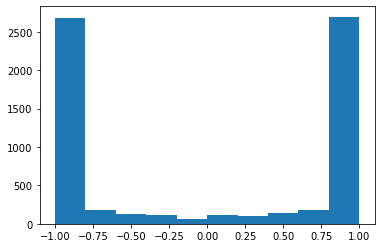

In [21]:
plt.hist(h.view(-1))
plt.show()

The fact that h is either -1 or 1 is a problem at initialization. The reason this happens is that the activation function is acting on a wide distribution:

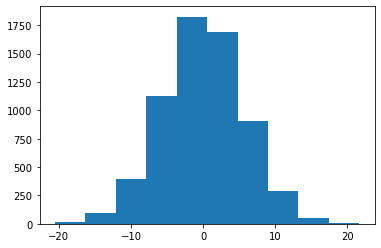

In [22]:
plt.hist((emb.view(-1, block_size*10) @ W1 + b1).view(-1))
plt.show()

This is an issue because backpropagation for tanh is grad += (1-tanh^2) * grad

When tanh is either +1 or -1, the gradient is not backpropagated. This means that the parameters playing a role before the activation function is applied are effectively irrelevant when it comes to modifying the loss.

We have to narrow down emb * W1 + b1

In [6]:
C = torch.randn((27, 10))
# Layer 1
W1 = torch.randn((block_size*10 , 200)) * 0.2
b1 = torch.randn(200) * 0.01
# Layer 2
W2 = torch.randn((200, 27)) * 0.01
b2 = torch.randn(27) * 0


ix = torch.randint(0, Xtr.shape[0], (32,))
x, y = Xtr[ix], Ytr[ix]

# Forward
emb = C[x] # emb = C[X]
l1 = emb.view(-1, block_size*10) @ W1 + b1
h = torch.tanh( l1 )
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y) # loss = F.cross_entropy(logits, Y)


print(loss.item())

3.3228654861450195


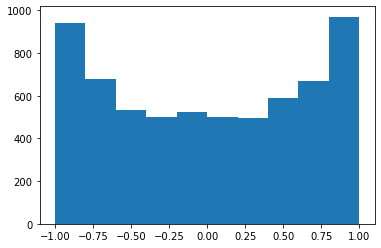

In [7]:
plt.hist(h.view(-1))
plt.show()